## Feature engineering

### Load Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 8.3 MB/s 


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/riiid/riiid-test-answer-prediction.zip (Unzipped Files)/sample_riiid_train.csv')

In [ ]:
df.head()

,Unnamed: 0,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,624,624,0,13134,3926,False,0,3,1,NaN,NaN
1,625,625,23840,13134,564,False,1,1,0,22000.0,False
2,626,626,46834,13134,3865,False,2,1,0,18000.0,False
3,627,627,64749,13134,4231,False,3,1,1,19000.0,False
4,628,628,113000,13134,3684,False,4,1,1,13000.0,False


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,624,0,13134,3926,False,0,3,1,NaN,NaN
1,625,23840,13134,564,False,1,1,0,22000.0,False
2,626,46834,13134,3865,False,2,1,0,18000.0,False
3,627,64749,13134,4231,False,3,1,1,19000.0,False
4,628,113000,13134,3684,False,4,1,1,13000.0,False


In [ ]:
len(df), len(df.user_id.unique())

(1069559, 4000)

### Preprocess

In [ ]:
def preprocess_user_id(df) :
    user_answer = df[['user_id','answered_correctly']]
    users = df.user_id.unique()

    # user cumulative count
    count = np.array([1]*len(df))
    for user in users :
        tmp = df[df.user_id == user]
        idx = tmp.index
        count[idx.min():idx.max()+1] = np.cumsum(count[idx.min():idx.max()+1])
    df['user_count'] = count

    # user cumulative correctness
    accu = np.array([0]*len(df))
    for user in users :
        tmp = df[df.user_id == user]
        idx = tmp.index
        accu[idx.min():idx.max()+1] = np.cumsum(tmp.loc[idx.min():idx.max()+1, 'answered_correctly'])
    user_correctness = accu/count
    df['user_correctness'] = user_correctness

    # shift correctness
    for user in users :
        tmp = df[df.user_id == user]
        idx = tmp.index
        df.loc[idx.min():idx.max()+1, 'user_correctness_shift'] = df.loc[idx.min():idx.max()+1, 'user_correctness'].shift(1)
    df['user_correctness_shift'].fillna(0)

    # diff btw timestamp
    df['shift'] = df['timestamp'].shift(1)
    df['lag'] = df['timestamp'] - df['shift']
    df.loc[df.lag<0, 'lag']=0

In [ ]:
preprocess_user_id(df)
len(df), len(df.user_id.unique())

(1069559, 4000)

In [ ]:
def preprocess_content(df) :
    user_answer = df[['user_id','answered_correctly']]
    users = df.user_id.unique()
    
    # if watch lecture
    watch_lec = [1]*len(df)
    for user in users :
        tmp = df[df.user_id == user]
        idx = tmp.index
        watch_lec[idx.min():idx.max()+1] = np.cumsum(tmp.loc[idx.min():idx.max()+1,'content_type_id'])

    df['watch_lec'] = watch_lec
    df['watch_lec'] = df['watch_lec'].replace(False, 0)

    # questions counts and mean
    qu_df = df.loc[df.content_type_id == False, ['content_id','answered_correctly']]
    qu_df = qu_df.groupby('content_id')['answered_correctly'].agg(['mean','count'])

    df['content_count']=[0]*len(df)
    df['content_count'] = df['content_id'].map(qu_df['count']).fillna(0).astype('int32')
    df['content_mean'] = df['content_id'].map(qu_df['mean'])

    # questions has explanation
    df.prior_question_had_explanation = df.prior_question_had_explanation.apply(bool)

In [ ]:
preprocess_content(df)

In [ ]:
questions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/riiid/riiid-test-answer-prediction.zip (Unzipped Files)/questions.csv')

In [ ]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [ ]:
def preprocess_questions(df, questions):
    #tags
    tag = questions["tags"].str.split(" ", n = 10, expand = True) 
    tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
    questions =  pd.concat([questions,tag],axis=1)
    questions['tags1'] = pd.to_numeric(questions['tags1'], errors='coerce')
    questions['tags2'] = pd.to_numeric(questions['tags2'], errors='coerce')
    questions['tags3'] = pd.to_numeric(questions['tags3'], errors='coerce')
    questions['tags4'] = pd.to_numeric(questions['tags4'], errors='coerce')
    questions['tags5'] = pd.to_numeric(questions['tags5'], errors='coerce')
    questions['tags6'] = pd.to_numeric(questions['tags6'], errors='coerce')

    #merge
    df = df.merge(questions, left_on='content_id', right_on='question_id', how='left')

    #fill_na
    df.fillna(0, inplace=True)

    return df

In [ ]:
df = preprocess_questions(df, questions)
df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_count,user_correctness,user_correctness_shift,shift,lag,watch_lec,content_count,content_mean,question_id,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6
0,624,0,13134,3926,False,0,3,1,0.0,True,1,1.000000,0.000000,0.0,0.0,0,196,0.903061,3926.0,3926.0,3.0,5.0,75,75.0,0.0,0.0,0.0,0.0,0.0
1,625,23840,13134,564,False,1,1,0,22000.0,False,2,0.500000,1.000000,0.0,23840.0,0,129,0.666667,564.0,564.0,0.0,2.0,148 32 81 29,148.0,32.0,81.0,29.0,0.0,0.0
2,626,46834,13134,3865,False,2,1,0,18000.0,False,3,0.333333,0.500000,23840.0,22994.0,0,155,0.200000,3865.0,3865.0,2.0,5.0,55,55.0,0.0,0.0,0.0,0.0,0.0
3,627,64749,13134,4231,False,3,1,1,19000.0,False,4,0.500000,0.333333,46834.0,17915.0,0,234,0.435897,4231.0,4231.0,1.0,5.0,89,89.0,0.0,0.0,0.0,0.0,0.0
4,628,113000,13134,3684,False,4,1,1,13000.0,False,5,0.600000,0.500000,64749.0,48251.0,0,136,0.441176,3684.0,3684.0,1.0,5.0,55,55.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df[df.answered_correctly!=-1]

---
## Modeling


### train/valid/test set split

In [ ]:
from category_encoders import OrdinalEncoder
encoder = OrdinalEncoder()
tmp = df[['tags1','tags2','tags3','tags4','tags5','tags6']].astype(str)
tmp = encoder.fit_transform(tmp)
df[['tags1','tags2','tags3','tags4','tags5','tags6']] = tmp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
a = df.groupby('user_id')['row_id'].agg('count')
df['user_total_count'] =  df['user_id'].map(a).fillna(0).astype('int32')
df['percentage'] = df['user_count']/df['user_total_count']

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
target = 'answered_correctly'
features = ['prior_question_elapsed_time', 'prior_question_had_explanation',
       'user_count', 'user_correctness_shift', 
       'lag', 'watch_lec', 'content_count', 'content_mean', 
        'part', 'tags1', 'tags2',
       'tags3','tags4', 'tags5','tags6']

In [ ]:
test = df[df.percentage>0.85]
val = df[(df.percentage<=0.85)&(df.percentage>0.70)]
train = df[df.percentage<=0.70]

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

### Try:Other model



In [ ]:
# baseline model : logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_y_proba = lr.decision_function(X_val)
roc_auc_score(y_val, lr_y_proba)

0.4545978222927639

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model =  XGBClassifier(n_estimators=10000
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=10
                  , learning_rate=0.05
                 )

xgb_model.fit(X_train, y_train, 
          eval_set = [(X_train, y_train),(X_val, y_val)],
          eval_metric='auc',
          early_stopping_rounds=50,
          verbose = 50
          )

[0]	validation_0-auc:0.758578	validation_1-auc:0.759407
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.760658	validation_1-auc:0.761066
[2]	validation_0-auc:0.761981	validation_1-auc:0.76234
[3]	validation_0-auc:0.762549	validation_1-auc:0.762809
[4]	validation_0-auc:0.763237	validation_1-auc:0.76338
[5]	validation_0-auc:0.76351	validation_1-auc:0.763684
[6]	validation_0-auc:0.76372	validation_1-auc:0.763915
[7]	validation_0-auc:0.764153	validation_1-auc:0.764398
[8]	validation_0-auc:0.764409	validation_1-auc:0.764741
[9]	validation_0-auc:0.764612	validation_1-auc:0.764951
[10]	validation_0-auc:0.764734	validation_1-auc:0.765086
[11]	validation_0-auc:0.764966	validation_1-auc:0.7653
[12]	validation_0-auc:0.765177	validation_1-auc:0.76548
[13]	validation_0-auc:0.765452	validation_1-auc:0.765752
[14]	validation_0-auc:0.765585	validation_1-auc:0.765852
[15]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# xgboost 결과 : validation_0-auc:0.78566	validation_1-auc:0.754855

### lgbm model

In [ ]:
%%time

#lgbm model
model = LGBMClassifier(
    max_depth=20,learning_rate=0.05, n_estimators=10000, 
    random_state=42, n_jobs=-1
)

# model.save_model(f'model.txt')
# model.fit(X_train, y_train, 
#           eval_set = [(X_train, y_train), (X_val, y_val)],
#           eval_metric='auc',
#           early_stopping_rounds=100,
#           verbose=10
#           )

CPU times: user 23 µs, sys: 1 µs, total: 24 µs
Wall time: 26 µs


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# param = {
#     'max_depth': [3,5,7],
#     'learning_rate' : [0.05, 0.07, 0.1],
#     'subsample' : np.arange(0.1, 1.0, 0.1),
#     'colsample_bytree' : np.arange(0.7, 1.0, 0.1),
#     'n_estimators' : [1000, 5000, 10000]
# }

# clf = RandomizedSearchCV(
#     model, 
#     param_distributions=param, 
#     n_iter=30, 
#     cv=5,
#     scoring='roc_auc',
#     verbose=3,
#     n_jobs=-1,
#     random_state=42
# )

param = {
    'max_depth' : range(20, 30, 5),
    'learning_rate' : [0.05],
    'subsample' :[0.7,0.8]
}
gs = GridSearchCV(
    model,
    param_grid = param, 
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = 3,
    verbose=3
)

gs.fit(X_train, y_train);
print(gs.best_params_)
print(gs.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
# 1차 아무것도 안 넣은 거 : training's auc: 0.775052	valid_1's auc: 0.773252	
# max_depth=5,learning_rate=0.1, n_estimators=1000 : training's auc: 0.778357 / valid_1's auc: 0.773407
# max_depth=15,learning_rate=0.05 : training's auc: 0.780206 / valid_1's auc: 0.77417
# max_depth=20, learning_rate=0.05 : training's auc: 0.780986 / valid_1's auc: 0.774196
# tags6 삭제 : training's auc: 0.781792 / valid_1's auc: 0.774136

#### cross validation

In [ ]:
# 1step cross validation

cutoff_list = np.arange(0.7,0.84,0.01) 

def cv(cutoff_list) :
    result_dict = {}
    
    for cutoff in cutoff_list :
        val = df[(df.percentage<=0.85)&(df.percentage>cutoff)]
        train = df[df.percentage<=cutoff]
        
        X_train = train[features]
        y_train = train[target]
        
        X_val = val[features]
        y_val = val[target]
        print(f'{cutoff} start')
        model.fit(X_train, y_train,
                  eval_set = [(X_train, y_train), (X_val, y_val)],
                  eval_metric='auc',
                  early_stopping_rounds=100,
                  verbose=100)
        
        y_pred_proba = model.predict_proba(X_val)[:,1]
        result=roc_auc_score(y_val, y_pred_proba)
        result_dict[f'{cutoff}'] = result
        print(f'{cutoff} end')
        print('-----\n')
    return result_dict

In [ ]:
cv_dict = cv(cutoff_list)
print(cv_dict)

0.7 start
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771288	training's binary_logloss: 0.533201	valid_1's auc: 0.771917	valid_1's binary_logloss: 0.52365
[200]	training's auc: 0.775126	training's binary_logloss: 0.529371	valid_1's auc: 0.773492	valid_1's binary_logloss: 0.52176
[300]	training's auc: 0.777238	training's binary_logloss: 0.527294	valid_1's auc: 0.773936	valid_1's binary_logloss: 0.521299
[400]	training's auc: 0.779039	training's binary_logloss: 0.52553	valid_1's auc: 0.773944	valid_1's binary_logloss: 0.521265
[500]	training's auc: 0.780595	training's binary_logloss: 0.524022	valid_1's auc: 0.773987	valid_1's binary_logloss: 0.521258
Early stopping, best iteration is:
[465]	training's auc: 0.780091	training's binary_logloss: 0.524509	valid_1's auc: 0.774038	valid_1's binary_logloss: 0.521207
0.7 end
-----

0.71 start
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771251	training's binary_l

In [ ]:
cv_dict

{'0.7': 0.7740380026956633,
 '0.71': 0.7744486491918705,
 '0.72': 0.7742777793290953,
 '0.73': 0.7741709283802228,
 '0.74': 0.7736450929111636,
 '0.75': 0.7738482247345331,
 '0.76': 0.7755727845848804,
 '0.77': 0.7750711522510827,
 '0.78': 0.7760063543495451,
 '0.79': 0.7756229259867801,
 '0.8': 0.774231867445182,
 '0.81': 0.7744035487955822,
 '0.8200000000000001': 0.7745905449547228,
 '0.8300000000000001': 0.7744696026434148,
 '0.8400000000000001': 0.7781235858127038}

#### final model

In [ ]:
test = df[df.percentage>0.85]
train = df[df.percentage<=0.85]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
#lgbm model
model = LGBMClassifier(
    max_depth=20,learning_rate=0.05, n_estimators=10000, 
    random_state=42, n_jobs=-1
)


model.fit(X_train, y_train, 
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          early_stopping_rounds=100,
          verbose=10
          )


Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.58411	training's auc: 0.759199	valid_1's binary_logloss: 0.580557	valid_1's auc: 0.759897
[20]	training's binary_logloss: 0.559605	training's auc: 0.761489	valid_1's binary_logloss: 0.556089	valid_1's auc: 0.762175
[30]	training's binary_logloss: 0.547946	training's auc: 0.763283	valid_1's binary_logloss: 0.544141	valid_1's auc: 0.764026
[40]	training's binary_logloss: 0.541834	training's auc: 0.765043	valid_1's binary_logloss: 0.537977	valid_1's auc: 0.765588
[50]	training's binary_logloss: 0.538327	training's auc: 0.76646	valid_1's binary_logloss: 0.534552	valid_1's auc: 0.766698
[60]	training's binary_logloss: 0.535977	training's auc: 0.767838	valid_1's binary_logloss: 0.532402	valid_1's auc: 0.767717
[70]	training's binary_logloss: 0.534327	training's auc: 0.769006	valid_1's binary_logloss: 0.530971	valid_1's auc: 0.768576
[80]	training's binary_logloss: 0.533069	training's auc: 0.77003

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=20,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# model 저장

import joblib
joblib.dump(model, './lgbm_model.pkl')

['./lgbm_model.pkl']

#### feature importance

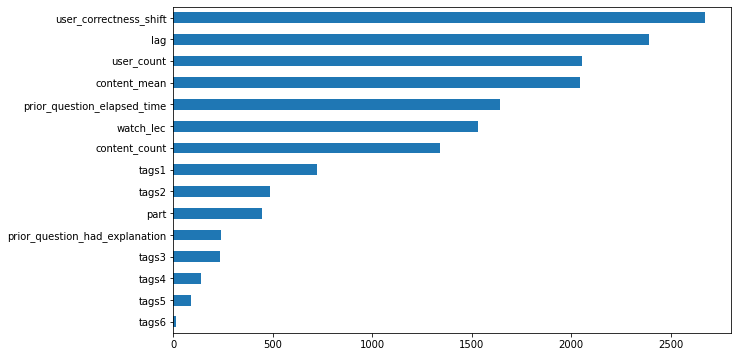

In [ ]:
import matplotlib.pyplot as plt

importances  = pd.Series(model.feature_importances_, X_train.columns)


plt.figure(figsize=(10,6))
importances.sort_values().plot.barh();

In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.4 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    model, # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val, y_val);

In [ ]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

tags6                            -0.000006
tags5                             0.000041
tags4                             0.000046
tags1                             0.000144
tags3                             0.000448
tags2                             0.000653
prior_question_had_explanation    0.000793
content_count                     0.002304
prior_question_elapsed_time       0.004447
part                              0.004703
user_count                        0.008685
watch_lec                         0.016789
lag                               0.027434
user_correctness_shift            0.071157
content_mean                      0.189023
dtype: float64

In [ ]:
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1890 ± 0.0026,content_mean
0.0712 ± 0.0023,user_correctness_shift
0.0274 ± 0.0008,lag
0.0168 ± 0.0012,watch_lec
0.0087 ± 0.0002,user_count
0.0047 ± 0.0005,part
0.0044 ± 0.0003,prior_question_elapsed_time
0.0023 ± 0.0002,content_count
0.0008 ± 0.0000,prior_question_had_explanation
0.0007 ± 0.0001,tags2


## Result Analysis

In [ ]:
!pip install pdpbox
!pip install shap

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

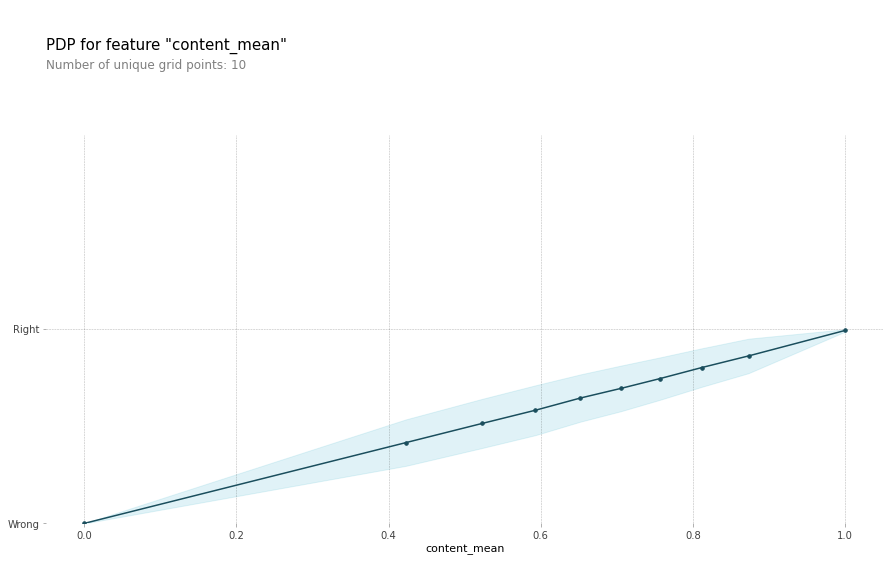

In [ ]:
isolated = pdp_isolate(model, dataset=X_train, model_features=X_train.columns, feature='content_mean')
pdp_plot(isolated, feature_name='content_mean')
plt.yticks([1, 0], ['Right', 'Wrong']);

정답율이 높을수록 맞을 확률이 높아진다. 양의 상관관계를 가진다. 

(1.0, 10000000000.0)

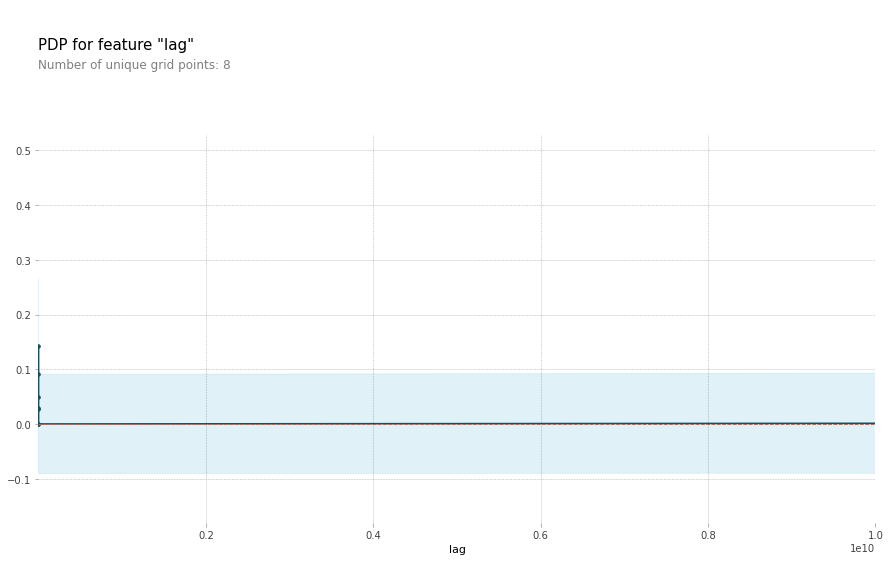

In [ ]:
isolated = pdp_isolate(model, dataset=X_train, model_features=X_train.columns, feature='lag')
pdp_plot(isolated, feature_name='lag')
plt.xlim((1, 10**10))
# plt.yticks([1, 0], ['Right', 'Wrong']);

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f86829ec190>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f86889fce50>})

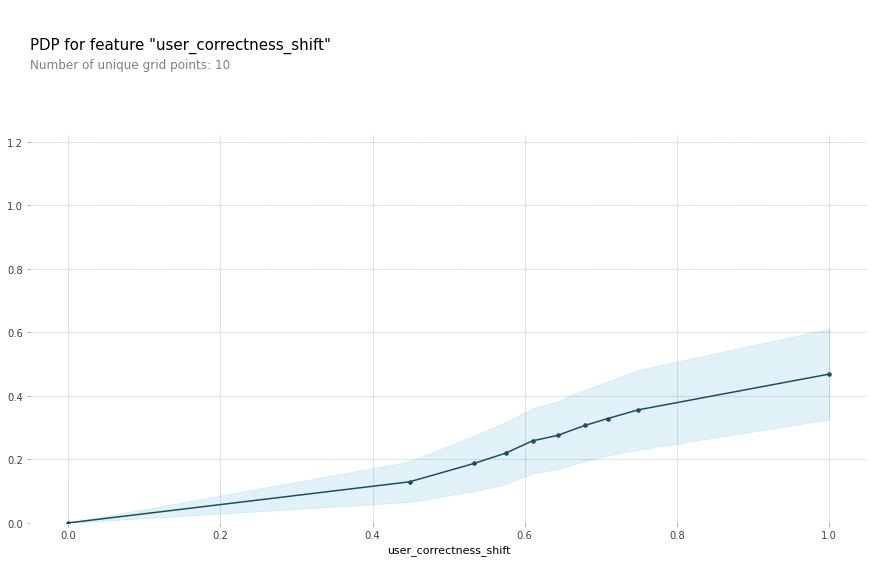

In [ ]:
# user_correctness_shift
isolated = pdp_isolate(model, dataset=X_train, model_features=X_train.columns, feature='user_correctness_shift')
pdp_plot(isolated, feature_name='user_correctness_shift')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


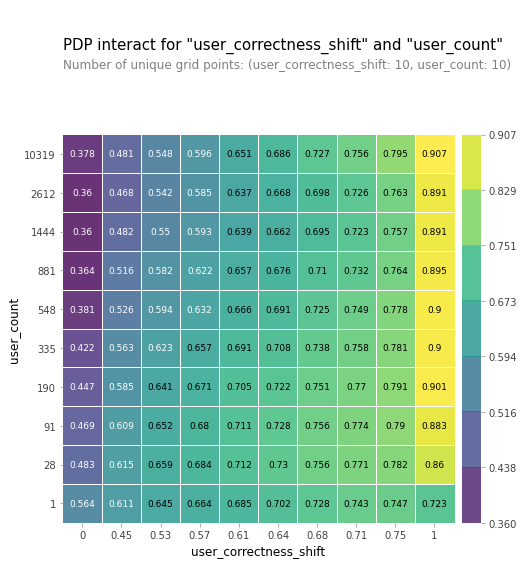

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['user_correctness_shift', 'user_count']

interaction = pdp_interact(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
import shap

In [ ]:
X_test.iloc[[0]]

,prior_question_elapsed_time,prior_question_had_explanation,user_count,user_correctness_shift,lag,watch_lec,content_count,content_mean,part,tags1,tags2,tags3,tags4,tags5,tags6
1056,18000.0,True,1057,0.685606,133843.0,7,67,0.641791,4.0,26,41,7,1,1,1


In [ ]:
row = X_test.iloc[[0]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1],
    features=row,
    link='logit'
)

In [ ]:
rows = X_test.iloc[:300]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rows)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=rows, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)


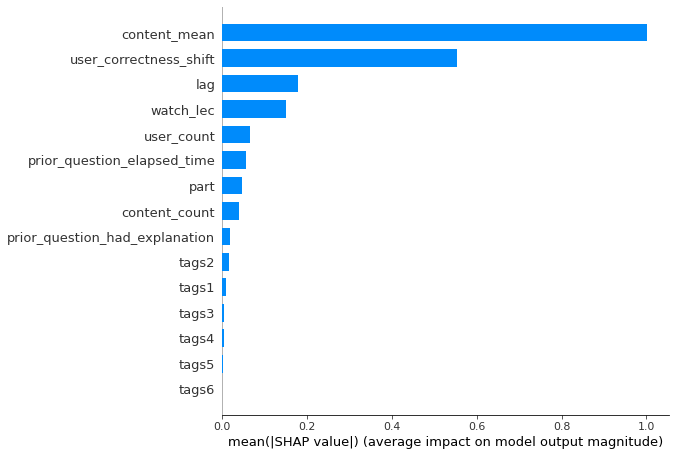

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[:1000])
shap.summary_plot(shap_values[1], X_test.iloc[:1000], plot_type='bar')

In [ ]:
# Requirements.txt 만들어야함

In [ ]:
pd.options.display.float_format = '{:.1f}'.format
X_train.loc[X_train.lag!=0, 'lag'].describe()

count        664035.0
mean       21442520.5
std       525782904.8
min              12.0
25%           27678.5
50%           45357.0
75%           99406.0
max     72999573992.0
Name: lag, dtype: float64

In [ ]:
pd.options.display.float_format = '{:.1f}'.format
X_train[X_train.lag != 0].sort_values(by='lag')

,prior_question_elapsed_time,prior_question_had_explanation,user_count,user_correctness_shift,lag,watch_lec,content_count,content_mean,part,tags1,tags2,tags3,tags4,tags5,tags6
574976,10000.0,True,36,0.8,12.0,0,647,0.4,2.0,2,2,7,3,1,1
240699,8000.0,True,125,0.5,13.0,0,108,0.5,5.0,6,1,1,1,1,1
324204,18000.0,True,407,0.7,19.0,11,116,0.7,2.0,2,2,7,5,1,1
339336,16000.0,True,113,0.8,24.0,0,92,0.7,2.0,46,26,7,6,1,1
1022195,27000.0,True,56,0.5,25.0,2,388,0.6,1.0,56,45,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96775,8000.0,True,85,0.6,58847980441.0,2,601,0.3,5.0,55,1,1,1,1,1
533993,3000.0,True,407,0.8,59682265742.0,2,214,0.6,5.0,42,1,1,1,1,1
27145,16000.0,False,130,0.8,60931719080.0,0,34,0.8,5.0,3,1,1,1,1,1
329061,16000.0,False,5,0.2,65291449644.0,0,1821,0.6,3.0,60,11,8,1,1,1


In [ ]:
m_lag = X_train.loc[X_train.lag!=0, 'lag']